인공지능 모델의 입력이 될 수 있는 것은 0과 1의 비트로 표현 가능한 숫자만으로 이루어진 매크릭스 뿐이다.   
예를 들어 A=0, B=1, Z=25에 대해 의미적으로 A와 B는 1만큼 멀고, A와 Z는 25만큼 멀다고 할 수 있을까? 대답은 No. 텍스트가 내포하는 의미를 기호가 직접 내포하지 않는다.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

#### Word to Vector

In [2]:
sentences = ['i feel hungry', 'i eat lunch', 'now i feel happy']

word_list = 'i feel hungry'.split( )
print(word_list)

['i', 'feel', 'hungry']


In [3]:
#dict

index_to_word={}  # 빈 딕셔너리를 만들어서

# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어준다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [4]:
word_to_index = {word:index for index,word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [5]:
print(word_to_index['feel'])

4


In [6]:
# 함수로 나타내기

#모든 문장은 <BOS> 로 시작하는 것으로 한다.
def get_encoded_sentence(sentence, word_to_index):
    return[word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [7]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode 해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [8]:
# 숫자 벡터로 된 문장 Decode

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [9]:
# 여러 개의 숫자 벡터로 encode 된 문장을 한꺼번에 decode 하는 함수

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


#### Embedding

텍스트를 숫자로 변환하였지만, 이 벡터는 텍스트에 담긴 언어의 의미와 대응되는 벡터가 아니다.   
이제 그 단어와 그 단어의 의미를 나타내는 벡터를 짝지어야 한다.   
그래서 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화하게 된다.   

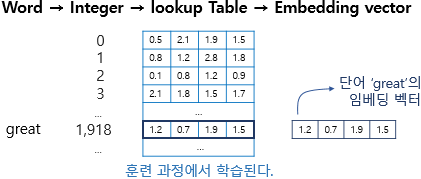

In [11]:
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
output = embedding(raw_inputs)
print(output)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

- raw_inputs 내 3개의 벡터의 길이는 각 4, 4, 5 이다. 현재 문장 벡터 길이가 일정하지 않으므로 일정하게 하여 에러를 없애보자

In [12]:
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs, value=word_to_index['<PAD>'], padding='post', maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


- 이제 embedding!

In [13]:
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.00720974 -0.01848279  0.00245458  0.02863647]
  [ 0.02040323 -0.02929467 -0.00574072 -0.01169145]
  [ 0.03646953 -0.03868284 -0.00168475 -0.04196642]
  [-0.01881492  0.0372267  -0.02207233  0.01451082]
  [ 0.04515184  0.0043344  -0.01704644 -0.00258135]]

 [[-0.00720974 -0.01848279  0.00245458  0.02863647]
  [ 0.02040323 -0.02929467 -0.00574072 -0.01169145]
  [ 0.02137974 -0.02910651 -0.04888778  0.01007932]
  [-0.01737741 -0.03852069 -0.04049595  0.0454541 ]
  [ 0.04515184  0.0043344  -0.01704644 -0.00258135]]

 [[-0.00720974 -0.01848279  0.00245458  0.02863647]
  [ 0.01194078  0.04580544  0.03272463 -0.02454314]
  [ 0.02040323 -0.02929467 -0.00574072 -0.01169145]
  [ 0.03646953 -0.03868284 -0.00168475 -0.04196642]
  [-0.02503704  0.01182849  0.03035815  0.00992374]]], shape=(3, 5, 4), dtype=float32)


### RNN

In [14]:
vocab_size = 10
word_vector_dim = 4

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))    #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


### IMDb 영화리뷰 감성분석

In [15]:
imdb = keras.datasets.imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 갯수 : {}, 테스트 갯수 : {}".format(len(X_train), len(X_test)))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 갯수 : 25000, 테스트 갯수 : 25000


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [16]:
print(X_train[0])  #1번째 리뷰 데이터
print('라벨 : ', y_train[0])   #1번째 리뷰 데이터의 라벨
print('1번째 리뷰 문장 길이 : ', len(X_train[0]))
print('2번째 리뷰 문장 길이 : ', len(X_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨 :  1
1번째 리뷰 문장 길이 :  218
2번째 리뷰 문장 길이 :  189


In [17]:
# IMDb 데이터셋에는 encode에 사용한 딕셔너리까지 함께 제공하고 있다.
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word,index in word_to_index.items()}
print(index_to_word[1])
print(word_to_index['the'])

the
1


- word_to_index는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어있다.

In [18]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word,index in word_to_index.items()}
print(index_to_word[1])
print(word_to_index['the'])

<BOS>
4


In [19]:
#Decode 잘 되는지 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨 : ', y_train[0])

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

- pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안 된다. 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.

In [20]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장 길이 평균 : ', np.mean(num_tokens))
print('문장 길이 최대 : ', np.max(num_tokens))
print('문장 길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequnces maxlen : ',maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함되는 중'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장 길이 평균 :  234.75892
문장 길이 최대 :  2494
문장 길이 표준편차 :  172.91149458735703
pad_sequnces maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함되는 중


In [21]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(25000, 580)


### 딥러닝 모델 설계 & 훈련

In [22]:
vocab_size = 10000
word_vector_dim = 16    #hyperparameter

#model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))    #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [23]:
# training dataset 25000 개 중 10000 개는 validation set으로 사용하자.

X_val = X_train[:10000]
y_val = y_train[:10000]

X_train_2 = X_train[10000:]
y_train_2 = y_train[10000:]

In [24]:
# model training

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20   #hyperparameter

history = model.fit(X_train_2, y_train_2, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
30/30 [==============================] - 7s 115ms/step - loss: 0.6926 - accuracy: 0.5239 - val_loss: 0.6889 - val_accuracy: 0.6277
Epoch 2/20
30/30 [==============================] - 3s 97ms/step - loss: 0.6841 - accuracy: 0.6495 - val_loss: 0.6613 - val_accuracy: 0.6768
Epoch 3/20
30/30 [==============================] - 3s 95ms/step - loss: 0.6208 - accuracy: 0.7226 - val_loss: 0.5274 - val_accuracy: 0.8013
Epoch 4/20
30/30 [==============================] - 3s 97ms/step - loss: 0.4840 - accuracy: 0.8505 - val_loss: 0.4510 - val_accuracy: 0.8489
Epoch 5/20
30/30 [==============================] - 3s 96ms/step - loss: 0.3977 - accuracy: 0.8938 - val_loss: 0.4071 - val_accuracy: 0.8596
Epoch 6/20
30/30 [==============================] - 3s 96ms/step - loss: 0.3280 - accuracy: 0.9113 - val_loss: 0.3757 - val_accuracy: 0.8600
Epoch 7/20
30/30 [==============================] - 3s 97ms/step - loss: 0.2738 - accuracy: 0.9255 - val_loss: 0.3523 - val_accuracy: 0.8679
Epoch 8/20
3

In [25]:
# 모델 평가

results = model.evaluate(X_test, y_test, verbose=2)

print(results)

782/782 - 18s - loss: 0.4697 - accuracy: 0.8494
[0.4696999192237854, 0.8493599891662598]


In [26]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


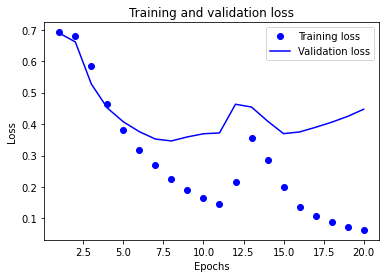

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

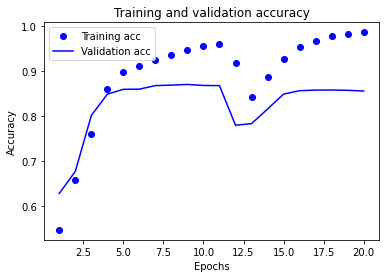

In [28]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Word2Vec 적용

- 우리가 사용한 model에 embedding 레이어가 있었다. 학습 과정을 거쳐 embedding layer에 학습된 워드 벡터들이 공간 상에 유의미한 형태로 학습되었을 것이다.

In [29]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   #(vocab_size, embedding_dim)

(10000, 16)


In [30]:
# 학습한 embedding 파라미터를 파일에 써서 저장한다.
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {} \n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.

# 단어 갯수에서 특수문자 4개는 제외하고 원드 벡터를 파일에 기록한다.
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {} \n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([-0.03464719,  0.0204576 , -0.03705275,  0.05059046,  0.02026547,
       -0.02683745, -0.05743534,  0.02002247, -0.0025463 ,  0.01659015,
        0.04957584,  0.01152133, -0.00542119, -0.02793144,  0.03833166,
        0.0065356 ], dtype=float32)

- 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있다. gensim을 사용하면 아래와 같이 해볼 수 있다.

In [32]:
word_vectors.similar_by_word("love")

[('ecstasy', 0.9640170931816101),
 ('futuristic', 0.9590373635292053),
 ('delirious', 0.9531728029251099),
 ('dangerously', 0.9524975419044495),
 ('restored', 0.9496148824691772),
 ('dancer', 0.9490361213684082),
 ('cleverly', 0.9462389945983887),
 ('medium', 0.9407634139060974),
 ('irving', 0.9397680163383484),
 ('metropolis', 0.9393457770347595)]

In [33]:
# Google word2vec

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
#300만 개의 단어를 모두 로딩하면 메모리 에러가 날 수 있으므로 limit=100만으로 한다.
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터이다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [34]:
word2vec.similar_by_word('love')

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

- 이전에 학습했던 모델의 임베딩 레이어를 word2vec의 것으로 교체하여 다시 학습해보자

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [36]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 114, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [37]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_2, y_train_2, epochs=epochs, batch_size=512, validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
30/30 [==============================] - 27s 666ms/step - loss: 0.7433 - accuracy: 0.4980 - val_loss: 0.6925 - val_accuracy: 0.4924
Epoch 2/20
30/30 [==============================] - 12s 393ms/step - loss: 0.6906 - accuracy: 0.5130 - val_loss: 0.6897 - val_accuracy: 0.5427
Epoch 3/20
30/30 [==============================] - 12s 395ms/step - loss: 0.6838 - accuracy: 0.5570 - val_loss: 0.6830 - val_accuracy: 0.5547
Epoch 4/20
30/30 [==============================] - 12s 391ms/step - loss: 0.6720 - accuracy: 0.5946 - val_loss: 0.6614 - val_accuracy: 0.6386
Epoch 5/20
30/30 [==============================] - 12s 394ms/step - loss: 0.6263 - accuracy: 0.6579 - val_loss: 0.5605 - val_accuracy: 0.7983
Epoch 6/20
30/30 [==============================] - 12s 392ms/step - loss: 0.5214 - accuracy: 0.8205 - val_loss: 0.5211 - val_accuracy: 0.8343
Epoch 7/20
30/30 [==============================] - 12s 392ms/step - loss: 0.4662 - accuracy: 0.8688 - val_loss: 0.4926 - val_accuracy: 0.8414

In [38]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

782/782 - 11s - loss: 0.4976 - accuracy: 0.8444
[0.49758180975914, 0.8443599939346313]
